![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)

# Model-Specific Interpretation with Grad-CAM for Signal Data

In this Notebook, we will demonstrate how to use Grad-CAM, a gradient-based pixel attribution method, for CNNs and interpret its results.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. To start working on the notebook, click on the following button. This will open this page in the Colab environment, and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/xai-for-cnn/3-Tutorial_Grad-CAM_for_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Google Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive, and you can navigate it through the lefthand panel in Colab. You might also have received an email that informs you about the access on your Google Drive.

In [9]:
# Mount drive folder to dbe abale to download repo
# from google.colab import drive
# drive.mount('/content/drive')

# Switch to correct folder'
# %cd /content/drive/MyDrive

In [ ]:
# Don't run this cell if you already cloned the repo 
# %rm -r XAI-Tutorials
# !git clone --branch main https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git

In [ ]:
# Install al required dependencies and package versions
# %cd XAI-Tutorials
# !pip install -r requirements_xai-for-cnn.txt
# %cd xai-for-cnn

### Imports

Let's start with importing all required Python packages.

In [12]:
import math
import torch
import numpy as np

import sys 
sys.path.append('./')
import utils

sys.path.append('../models')
from model_ECG import ECG, ResNetECG, ResNetBlockECG

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [13]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

--------

## Data Preparation and Model Loading

For this tutorial, we will use the **Electrocardiogram (ECG) Heartbeat Categorization Dataset**. The dataset comprises two groups of heartbeat signals, originating from two well-known heartbeat classification datasets - the MIT-BIH Arrhythmia Dataset and the PTB Diagnostic ECG Database. We used the MIT-BIH Arrhythmia Dataset to train our model. This dataset consists of 87554 samples for train, 21892 samples for test, and five categories (['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]).

The dataset is organized in CSV files. Inside every CSV file, there's a matrix structure. Each row in the matrix signifies an individual ECG signal instance. The last column in each row determines the specific category the example belongs to. For more details about the dataset, please refer to [Kachuee et al., 2018](https://doi.org/10.1109/ICHI.2018.00092).

Let's first prepare the test dataset:

In [14]:
!unzip ../data/dataset_ECG/ECG_test_data.zip -d ../data/dataset_ECG/ECG_test_data

Archive:  ../data/dataset_ECG/ECG_test_data.zip
  inflating: ../data/dataset_ECG/ECG_test_data/mitbih_test.csv  


We have trained a **modified version of ResNet-50 model for 1D convolutional data** for ten epochs on the ECG Dataset. The original ResNet-50 architecture typically employs 2D convolutional layers (conv2d) as it is primarily designed for processing 2D data, such as images. However, when adapting ResNet-50 for 1D data, such as time series or audio data, the architecture is modified to use 1D convolutional layers (conv1d) instead. This modification is essential to make the network suitable for analyzing 1D data, as the conv1d layers are specifically designed to process data with only one spatial dimension. 

The model shows a high accuracy of 99.37% and a low average loss of 0.061 on the test data . The F1 scores, which are the harmonic mean of precision and recall, are 99.19%, 81.33%, 95.93%, 81.31%, and 99.12% for the classes N, S, V, F, and Q, respectively. These scores suggest a balanced performance between precision and recall, with the second and fourth classes showing slightly lower F1 scores. 

If you are interested, you will find this class and the training script in [*model_ECG.py*](../models/model_ECG.py).

Let's set some paths. We provide the path of the model's weight and the location of the test data. 

In [15]:
model_weights_path = '../models/model_ECG_final_weights.pth'
test_data_path = '../data/dataset_ECG/ECG_test_data/mitbih_test.csv'

Now, let's load the test data and trained model:

In [16]:
ecg = ECG(test_data_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetECG(ResNetBlockECG, [2, 2, 2, 2], num_classes=5)
model = model.to(device)
model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device=device)))
_ = model.eval()

## Now, what does my model actually think is important in the data?

### Grad-CAM

**We prepared a small [Introduction to Grad-CAM](https://xai-tutorials.readthedocs.io/en/latest/_model_specific_xai/Grad-CAM.html) for you, to help you understand how this method works.**

*Note: we provide all references [here](https://xai-tutorials.readthedocs.io/en/latest/_model_specific_xai/Grad-CAM.html#references).*

In our scenario, the ResNet-50 architecture comprises a series of convolutional layers, succeeded by a fully connected layer, and a softmax layer. Given this setup, we can generate our Grad-CAM.

In the previous Notebook we showed you how to compute a localization map for Grad-Cam step by step and how to visualize it using a heatmap. You can find the two functions for the localization map calculation and conversion to heatmap in [utils.py](./utils.py).

Let's now generate the five Grad-CAMs for each class in the test set. Once the Grad-CAM is generated, we resize it to the same size as the original signal and normalize the values. We then plot the result using Matplotlib's `imshow` to display a Grad-CAM with a red color map (`cmap='Reds'`) over a signal plot. The aspect ratio is set to 'auto' to fit the image to the axes, and `extent` aligns the Grad-CAM's dimensions with the signal's length and value range. The Grad-CAM is fully opaque (`alpha=1.0`), providing a clear overlay to highlight regions in the signal that are influential for the model's predictions. 

In [17]:
def get_prediction(idx):
    signal = ecg[idx][0]
    signal_batch_dim = signal.unsqueeze(0).to(device)
    label = ecg[idx][1]

    localization_map = utils.calculate_localization_map(model, signal_batch_dim, label, dim=[0, 2])
    heatmap = utils.convert_localization_map_to_heatmap(localization_map, (signal.shape[1], signal.shape[0]))
    
    logits = model(signal_batch_dim) 
    pred_class = logits.argmax(dim=1).item()

    if pred_class == label:
        fig, axs = plt.subplots(figsize=(25,5))
        
        pcm = axs.imshow(heatmap, cmap='Reds',  aspect="auto", extent=[0, len(signal[0]), math.floor(signal[0].min()), math.ceil(signal[0].max())], alpha=1.0)
        axs.plot(signal[0], 'k')
        fig.colorbar(pcm, ax=axs, shrink=0.6)

        # Draw a grid with a spacing of 1 millimeter
        axs.set_xticks(np.arange(0, 188, 1), minor=True)
        axs.set_yticks(np.arange(0, 1, 0.01), minor=True)
        axs.grid(which='major', color='black', linestyle='-', linewidth=0.5)
        axs.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)

        plt.show()

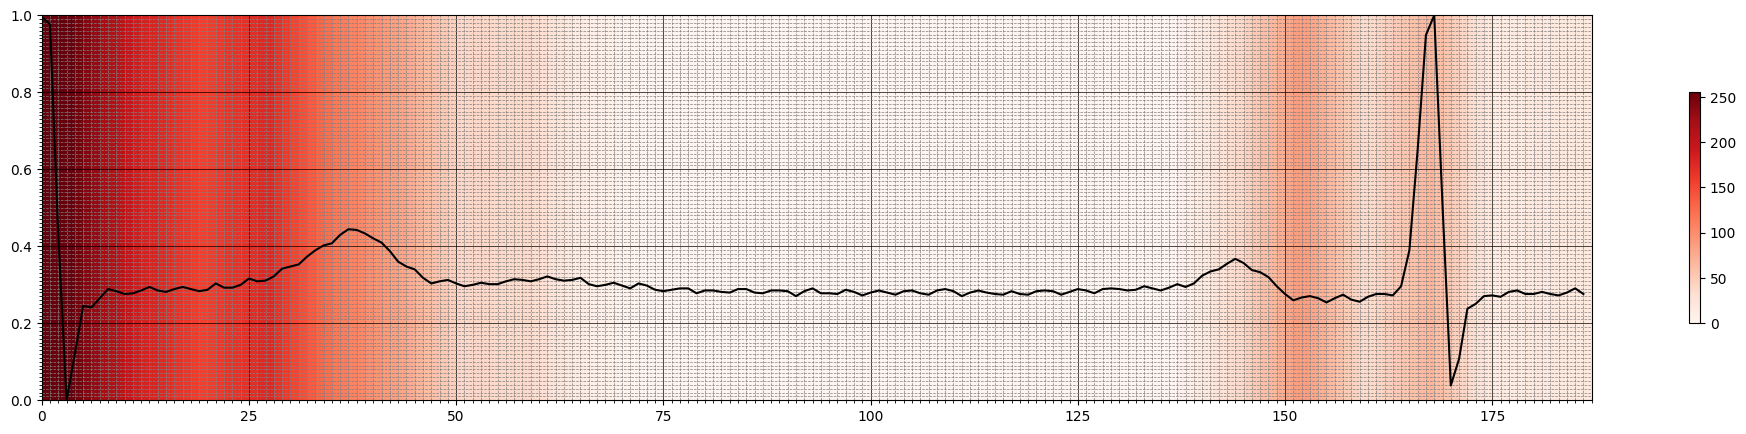

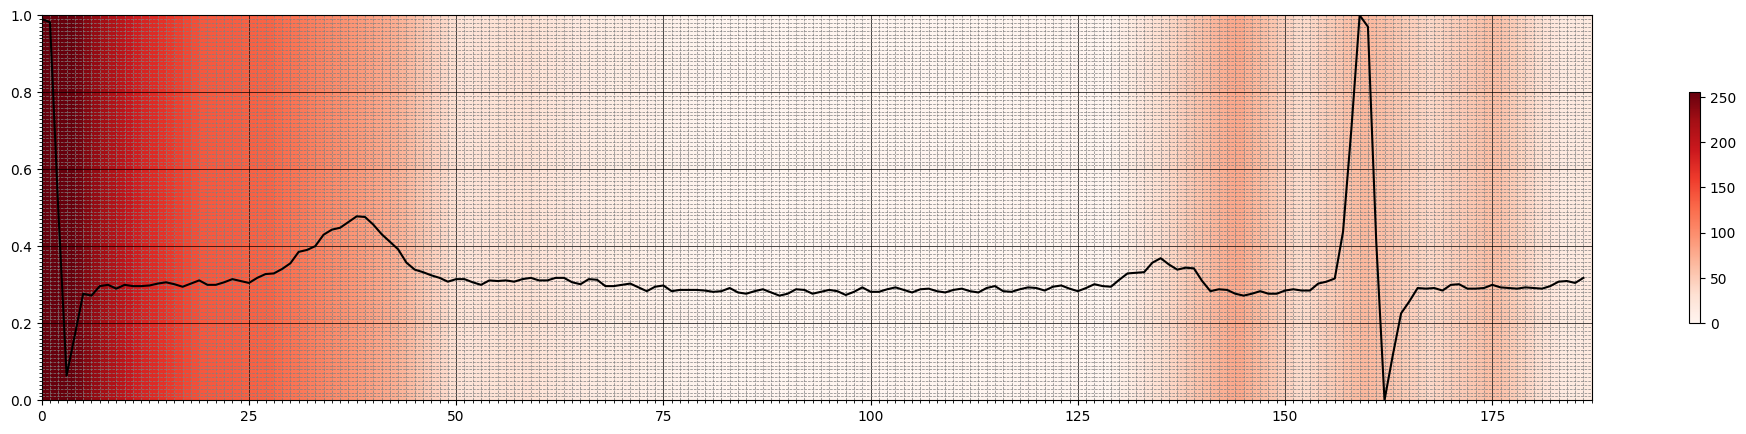

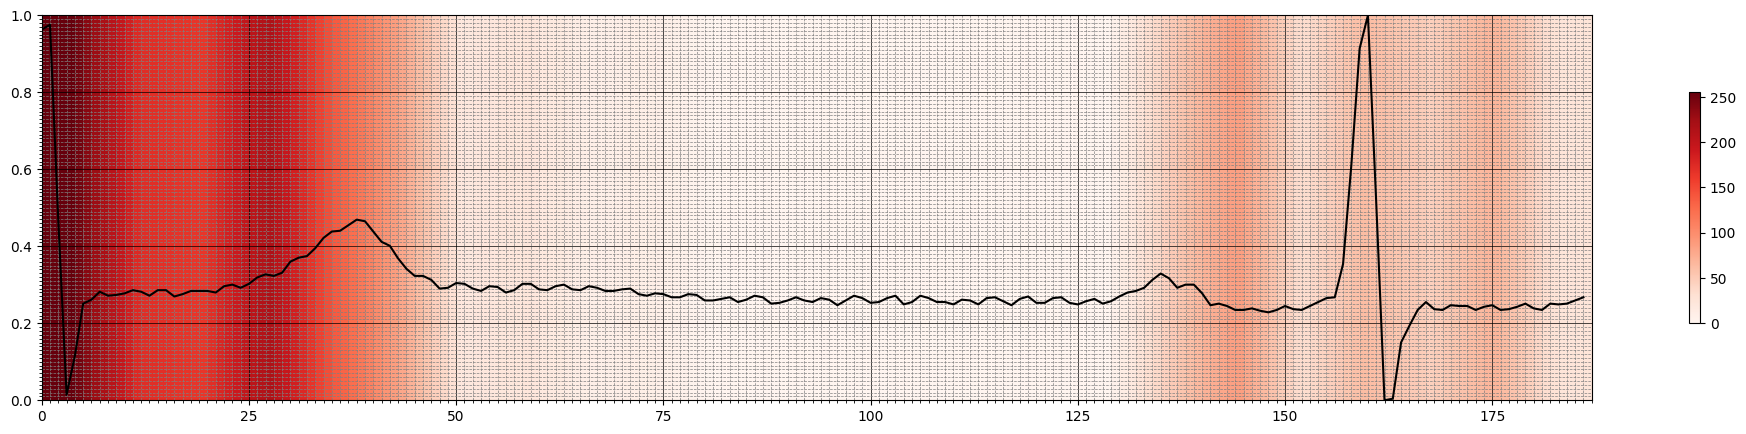

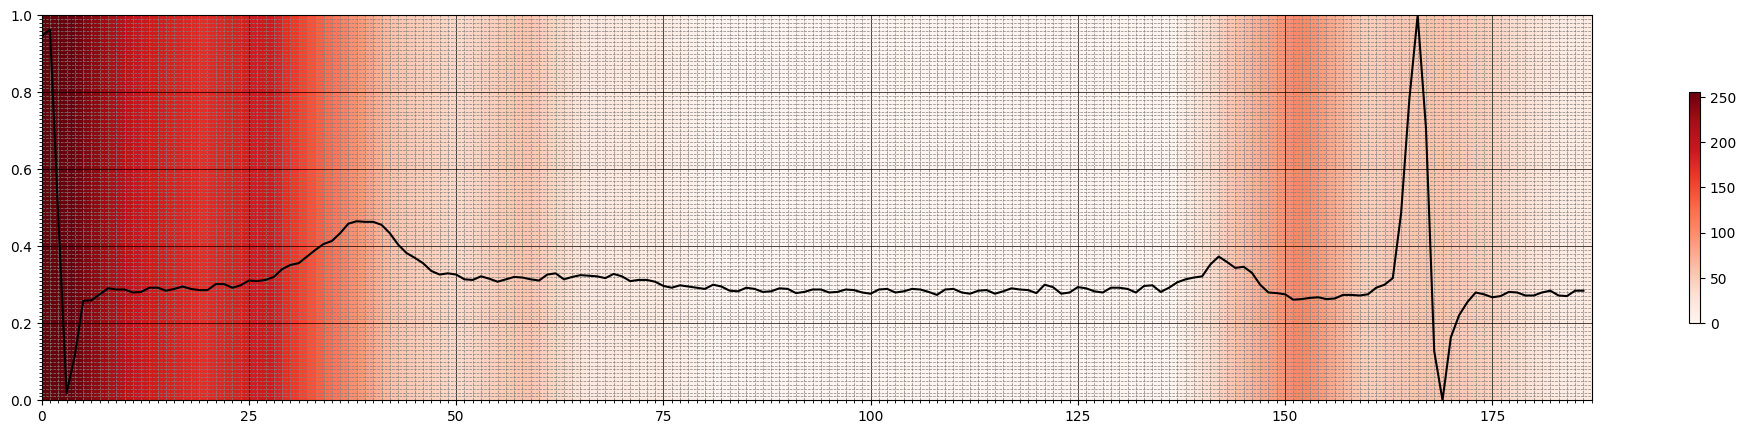

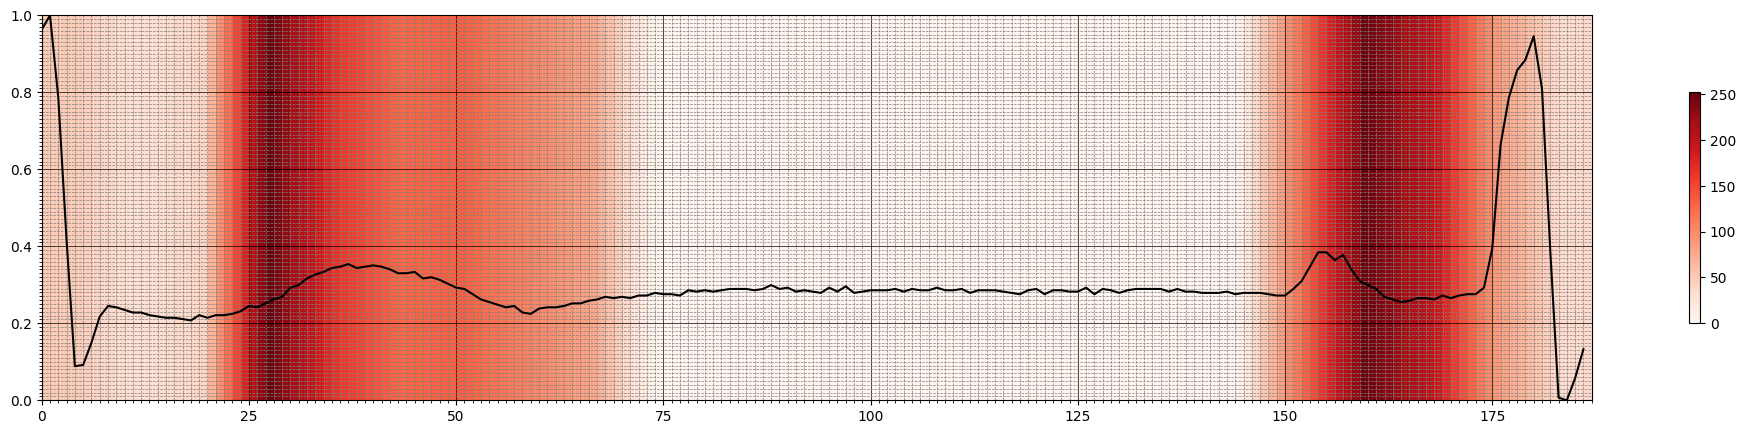

In [18]:
# Grad-CAMs that belongs to class N
normal_ecg_indexes = [936, 1452, 2824, 3878, 6041]
for i in normal_ecg_indexes:
  get_prediction(i)

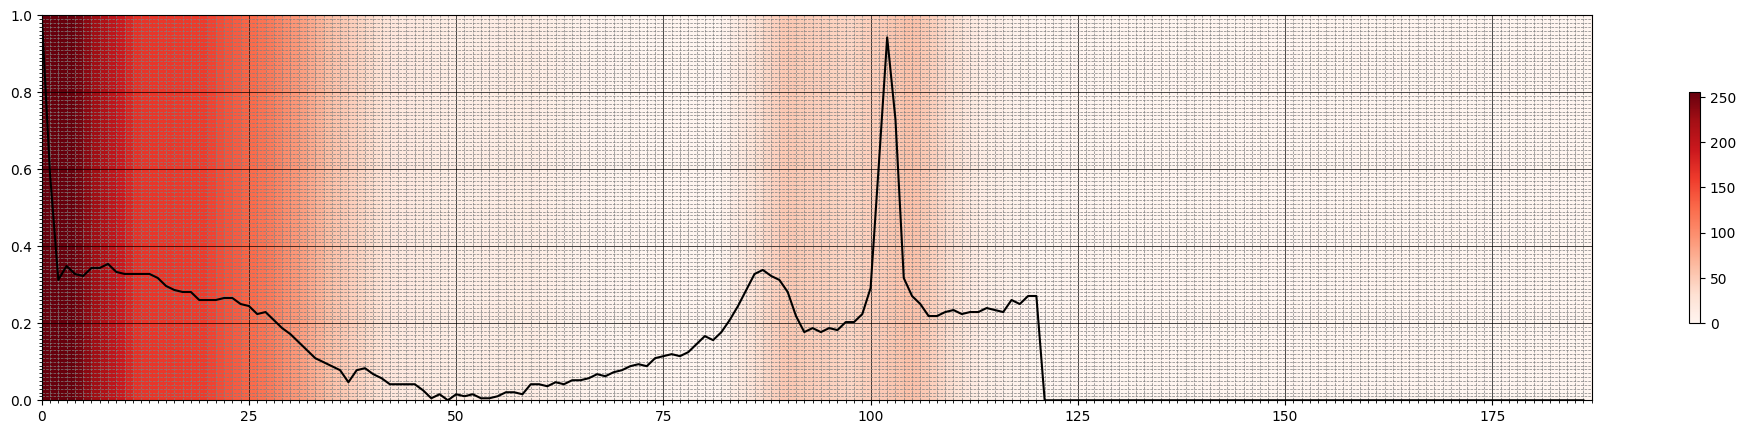

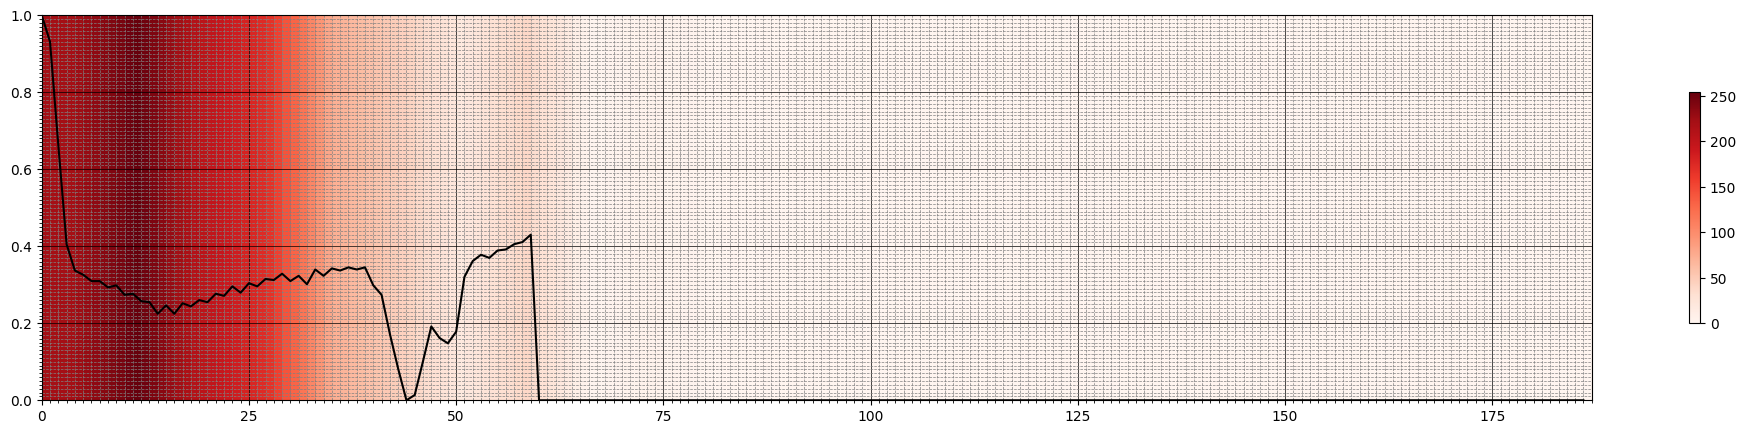

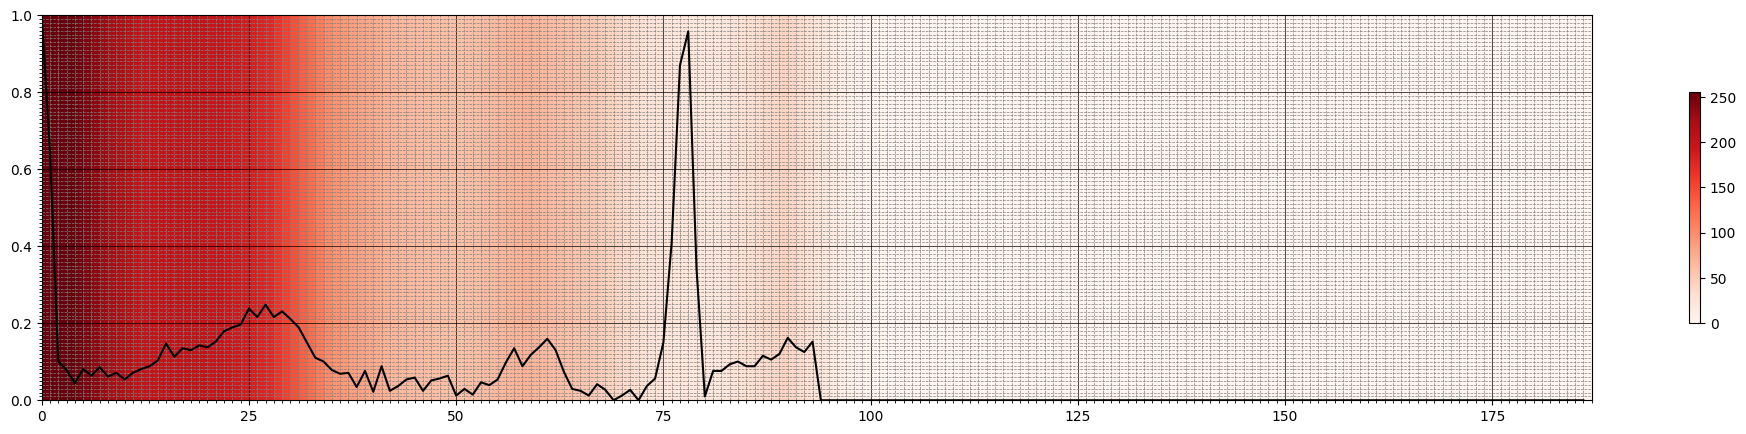

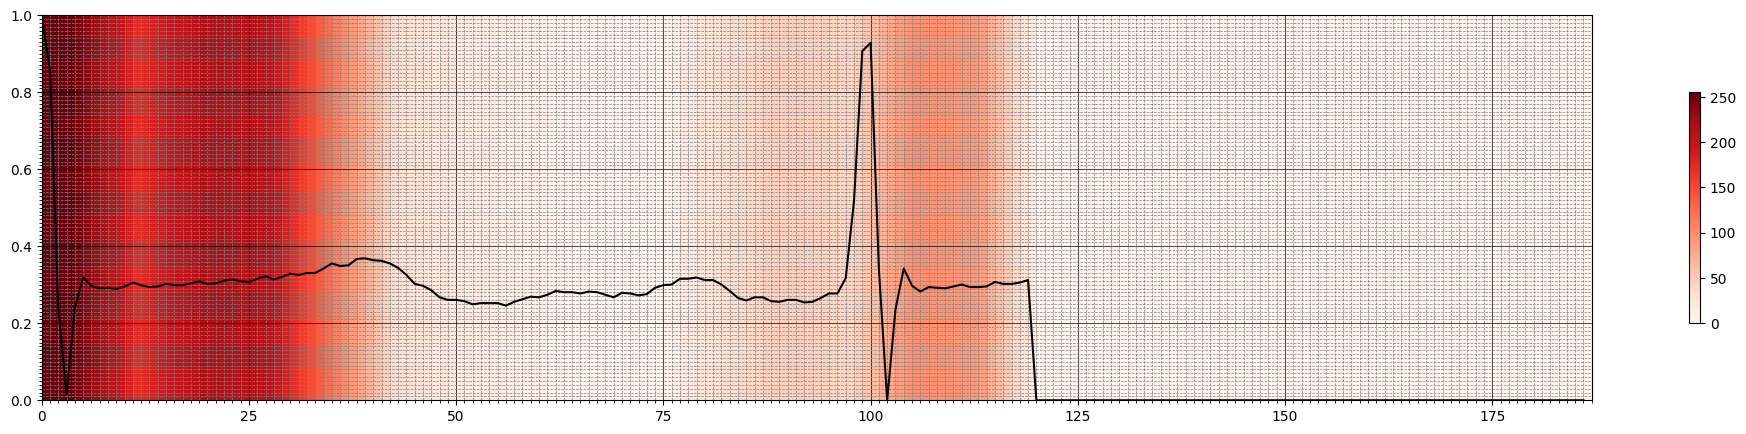

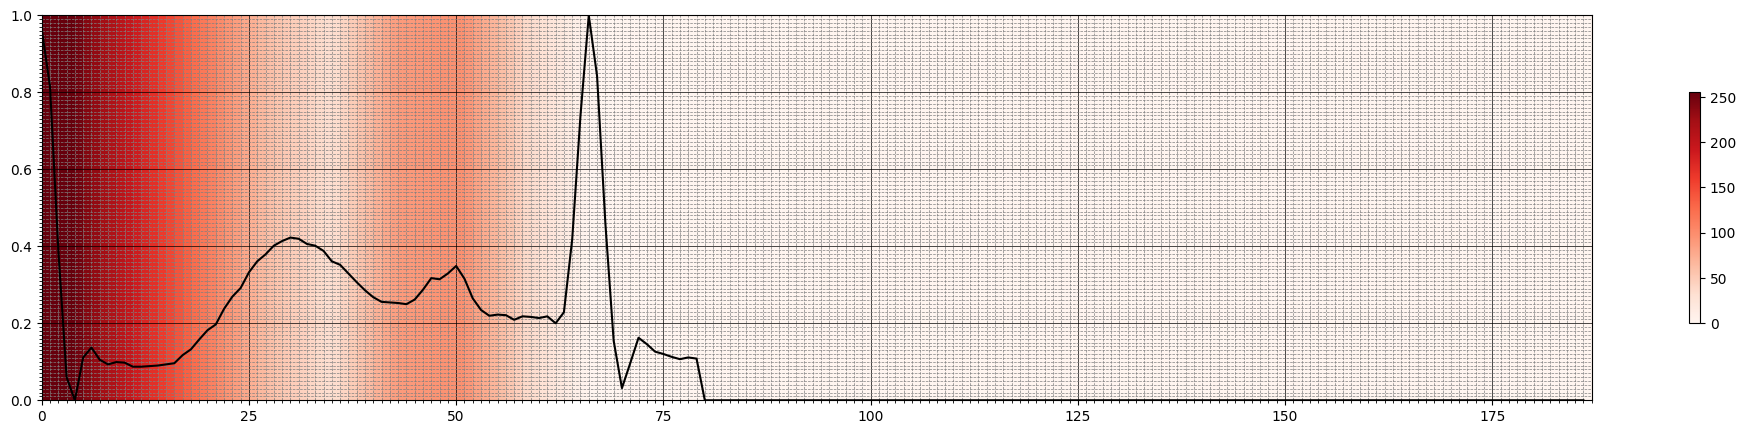

In [19]:
# Grad-CAMs that belongs to class S 
for i in range(18005,18010):
  get_prediction(i)

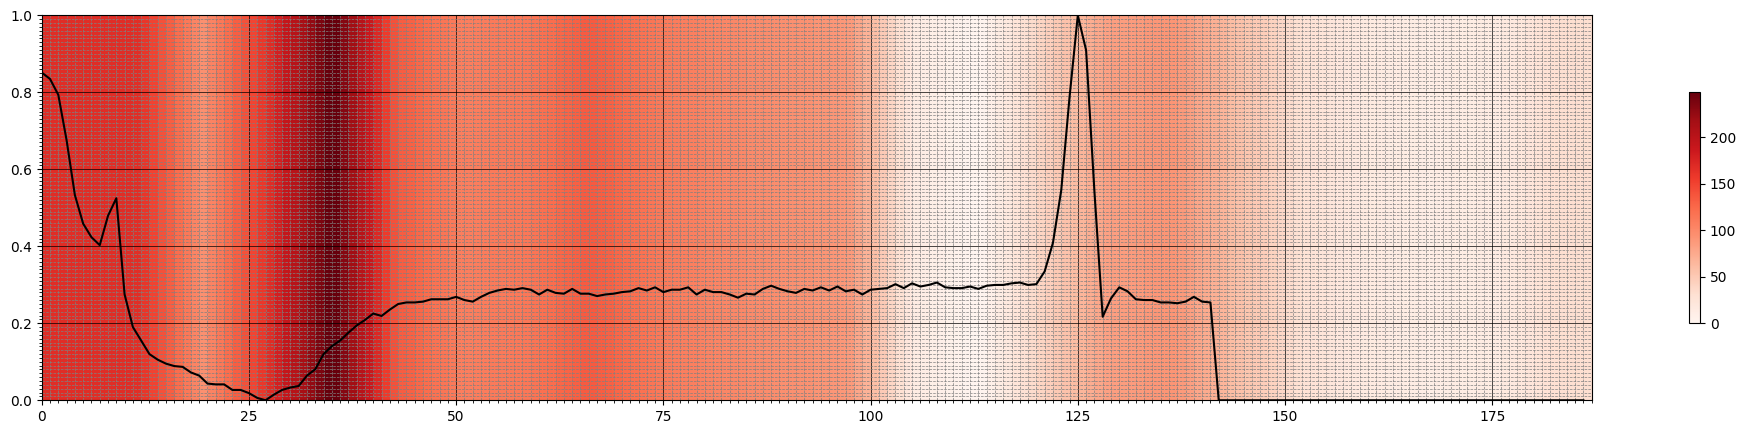

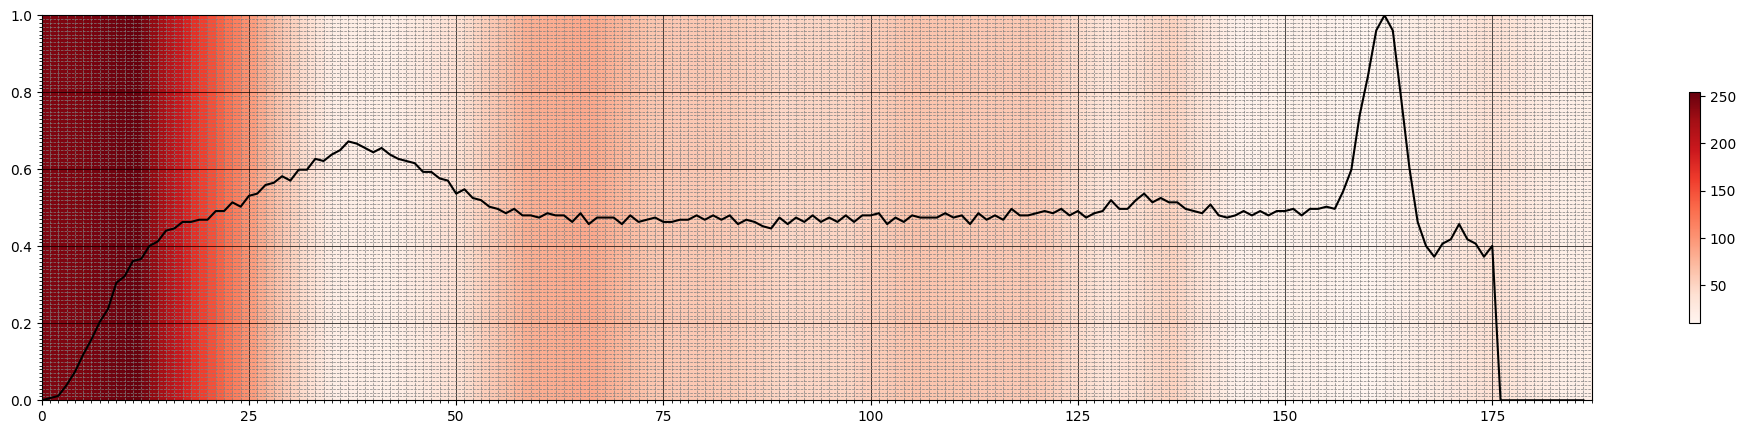

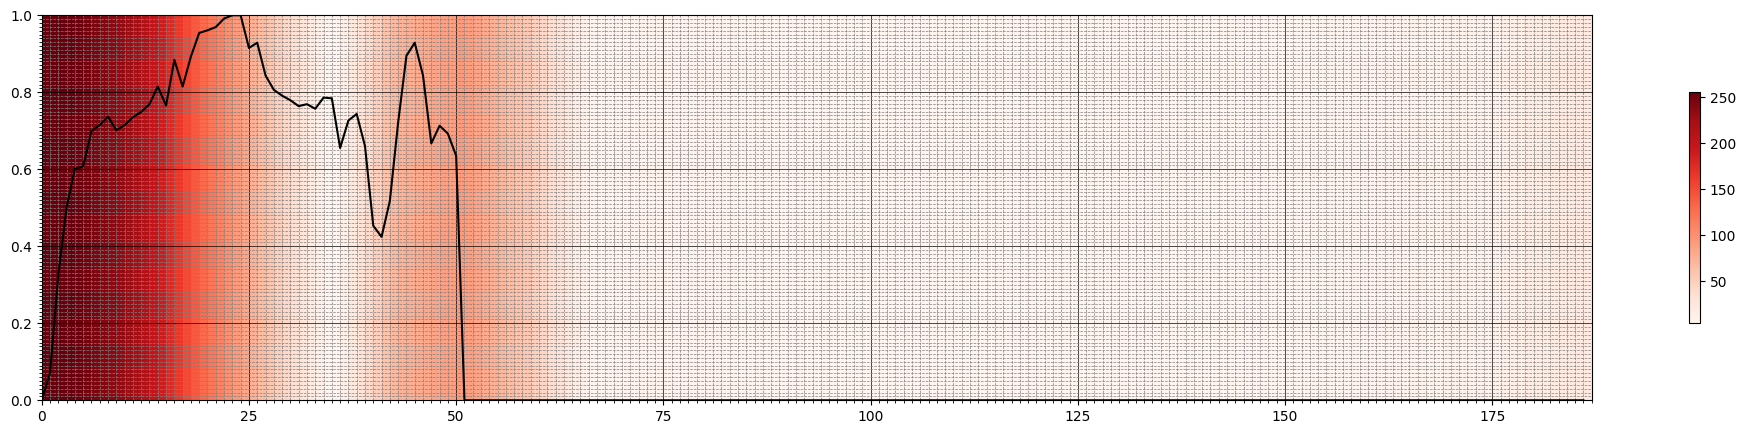

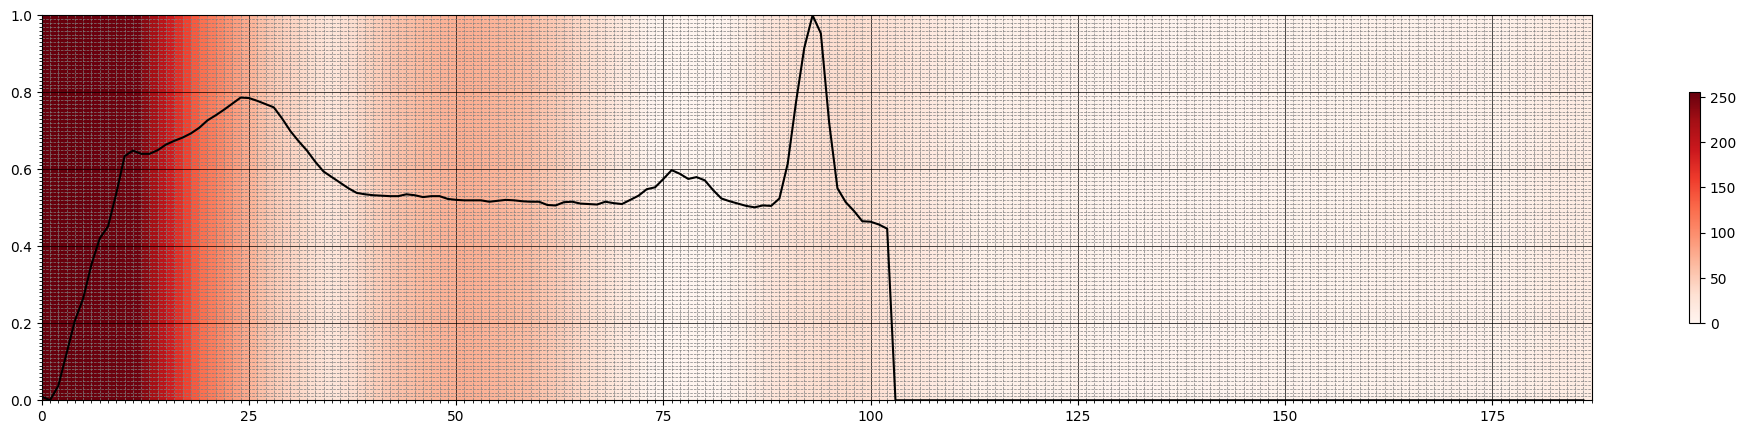

In [20]:
# Grad-CAMs that belongs to class V 
for i in range(18890,18895):
  get_prediction(i)

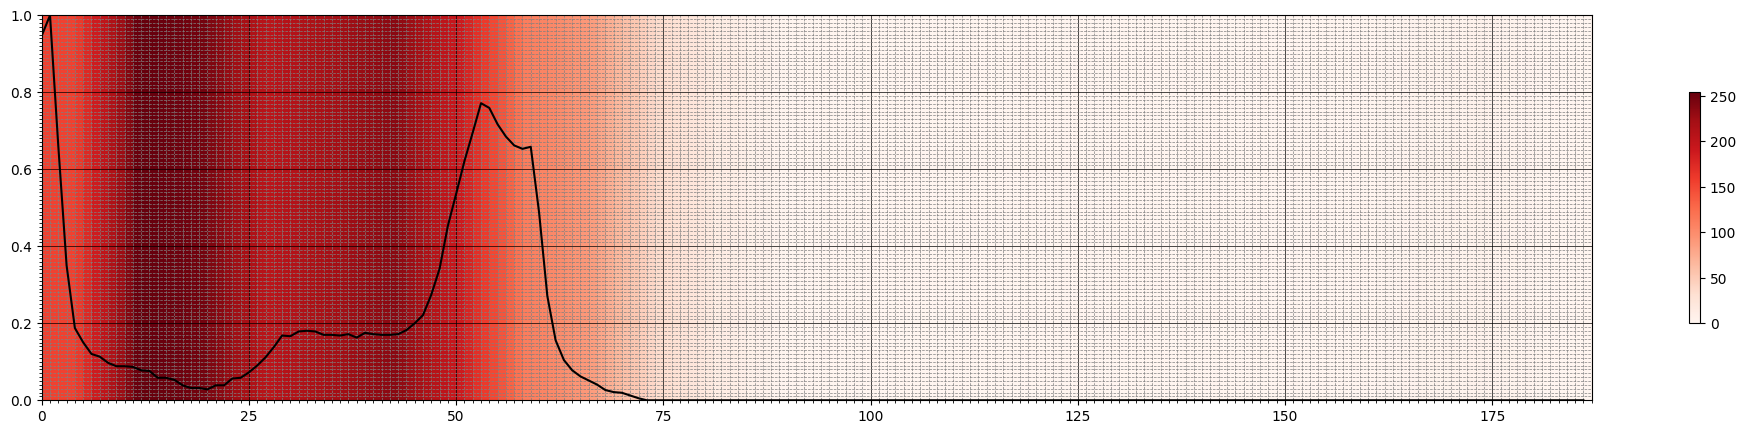

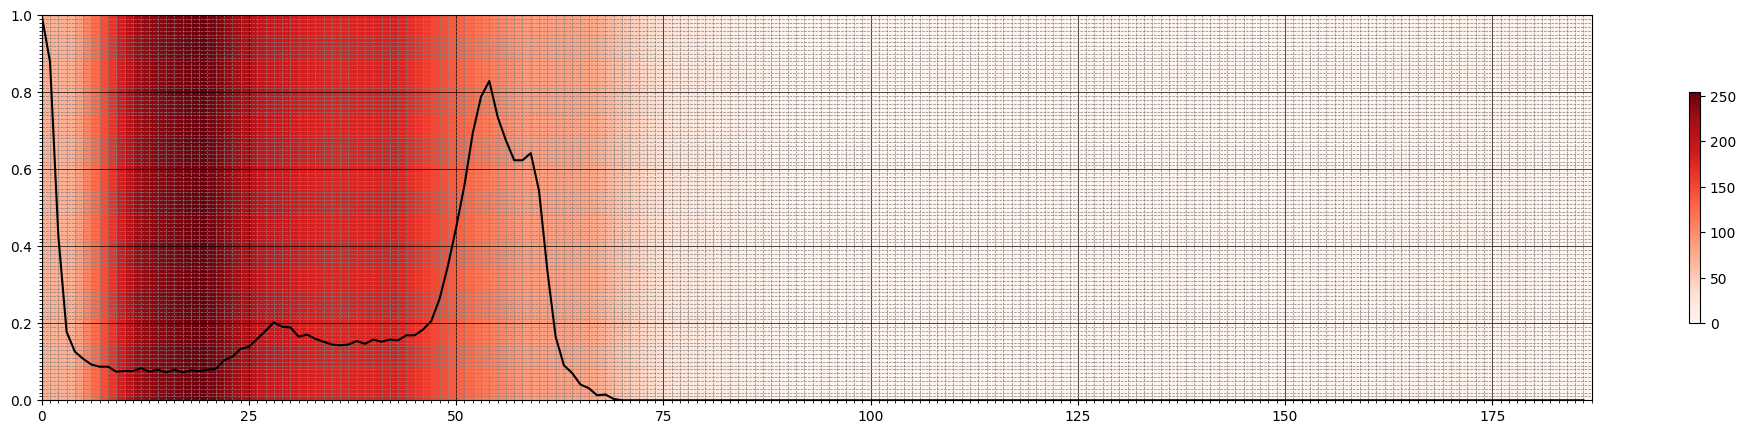

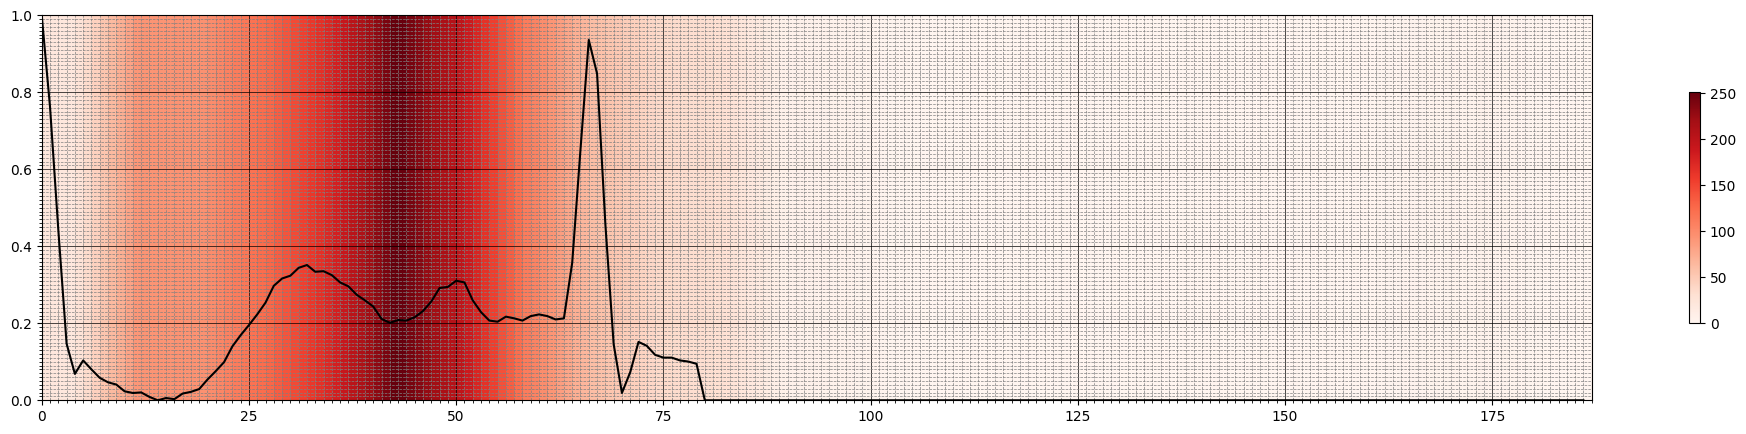

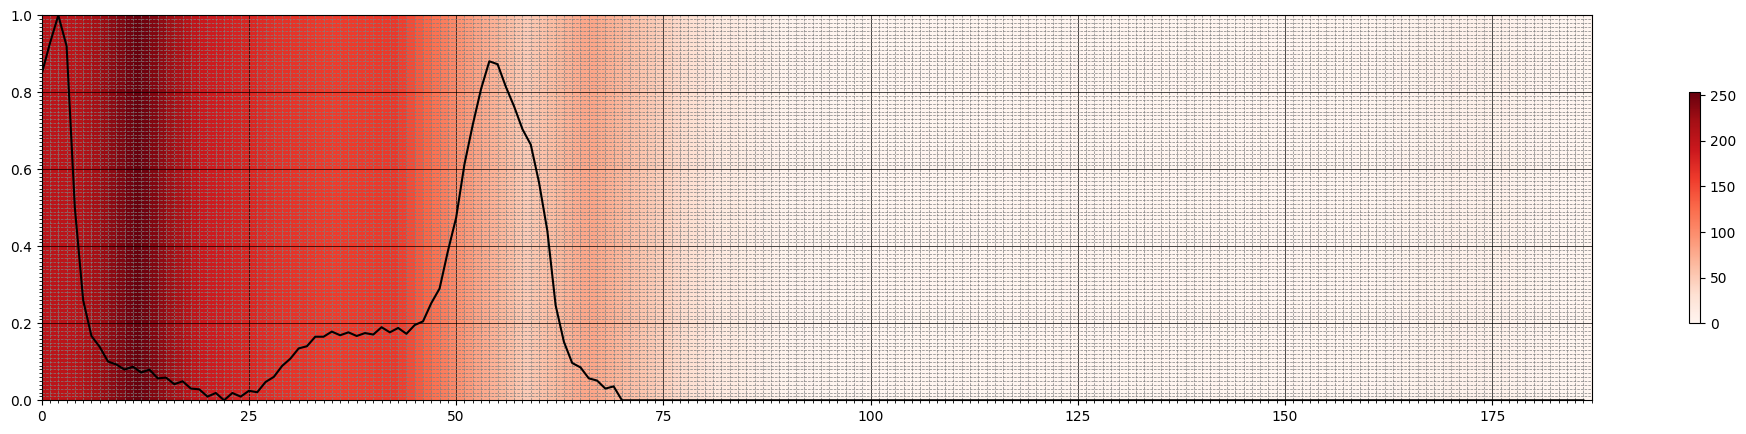

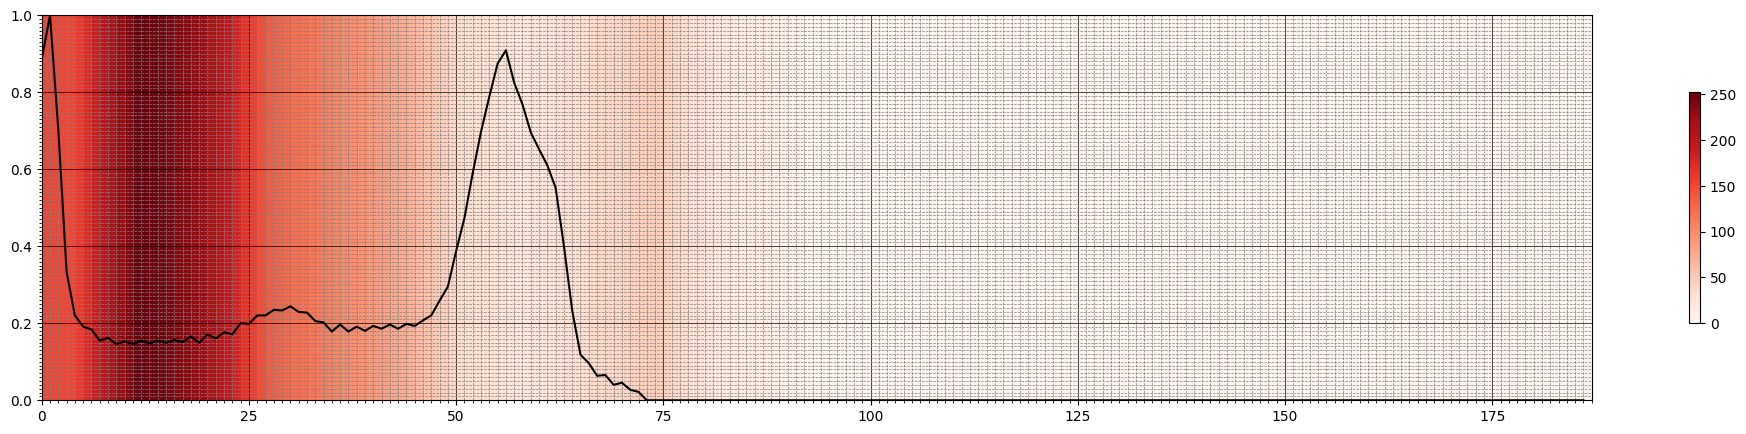

In [21]:
# Grad-CAMs that belongs to class F 
for i in range(20201,20207):
  get_prediction(i)

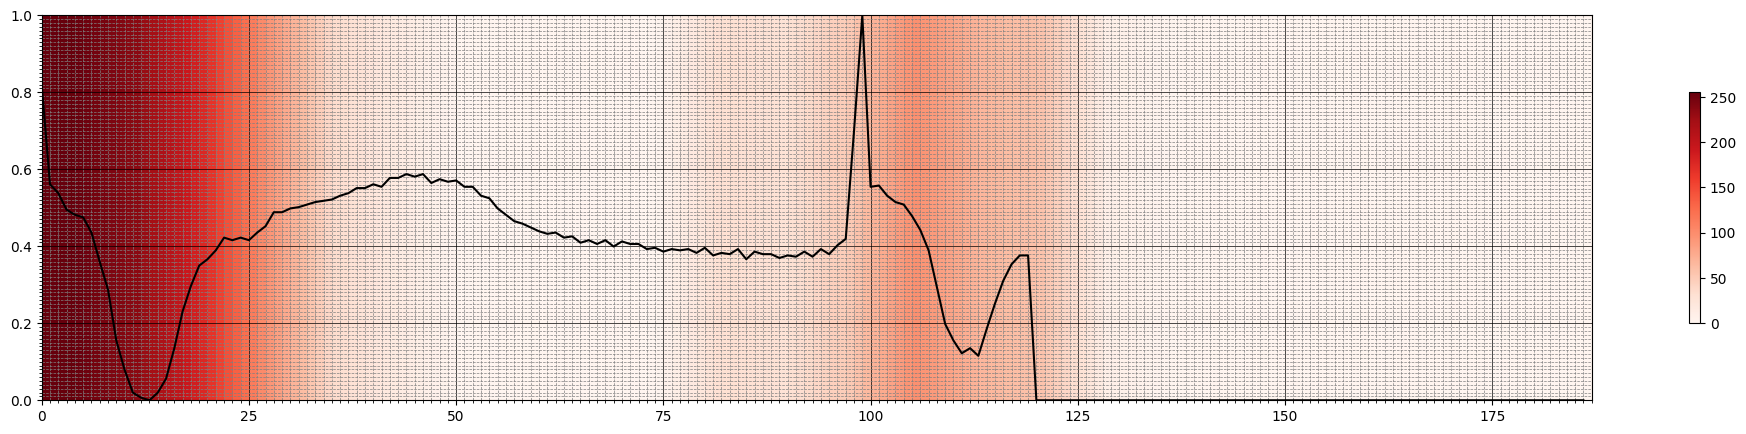

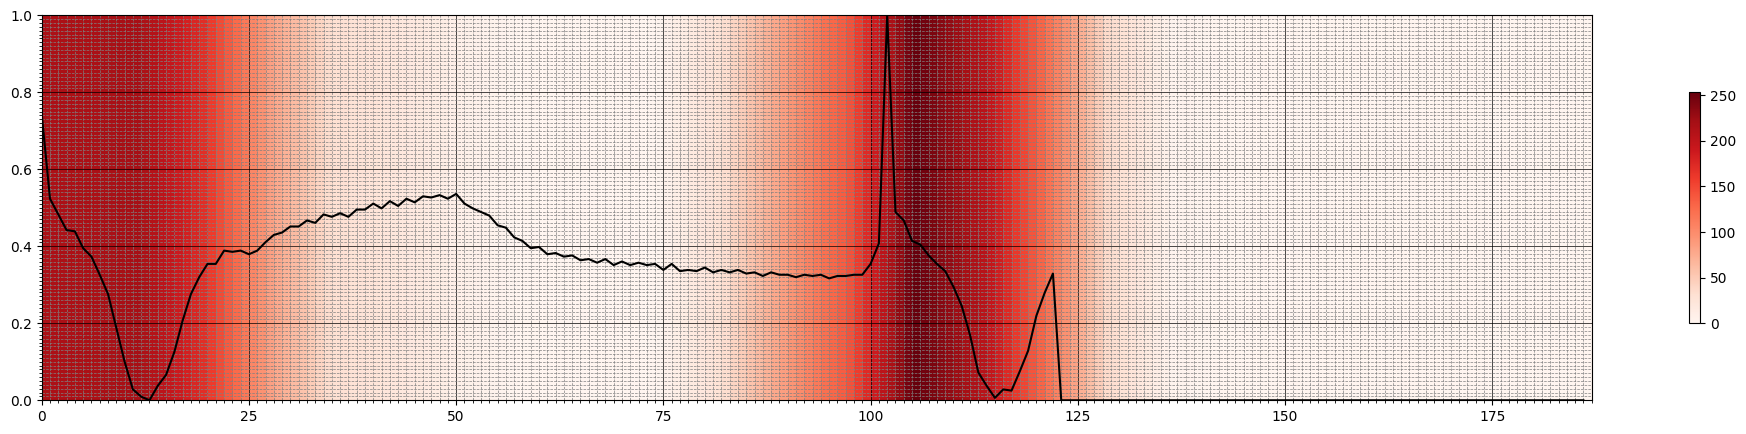

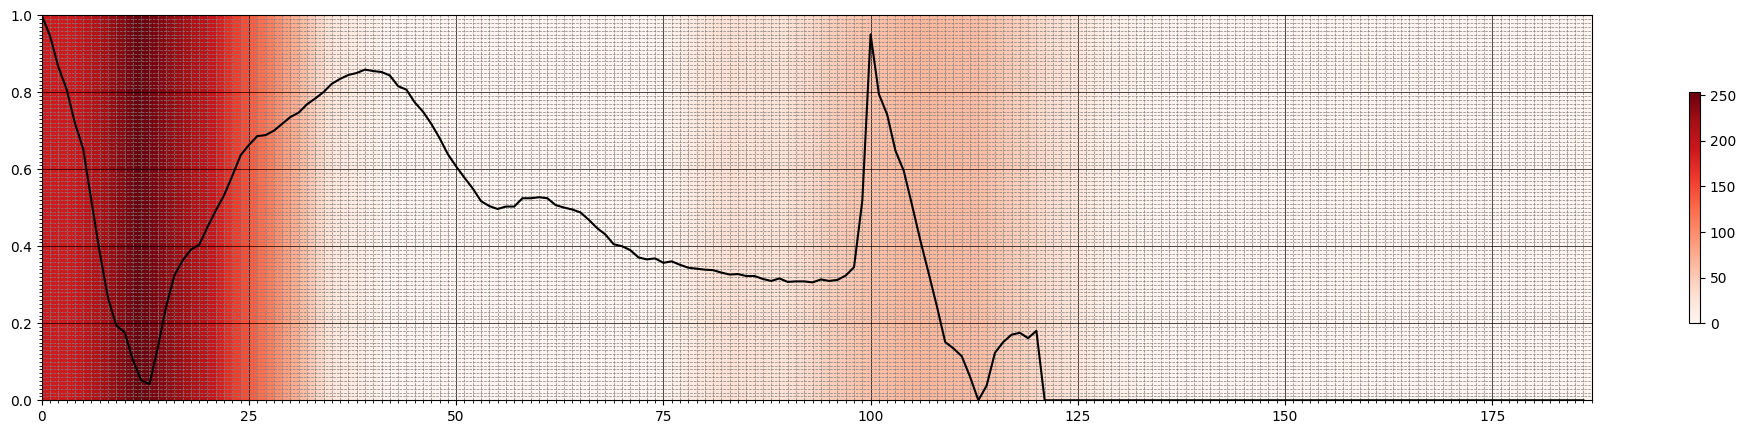

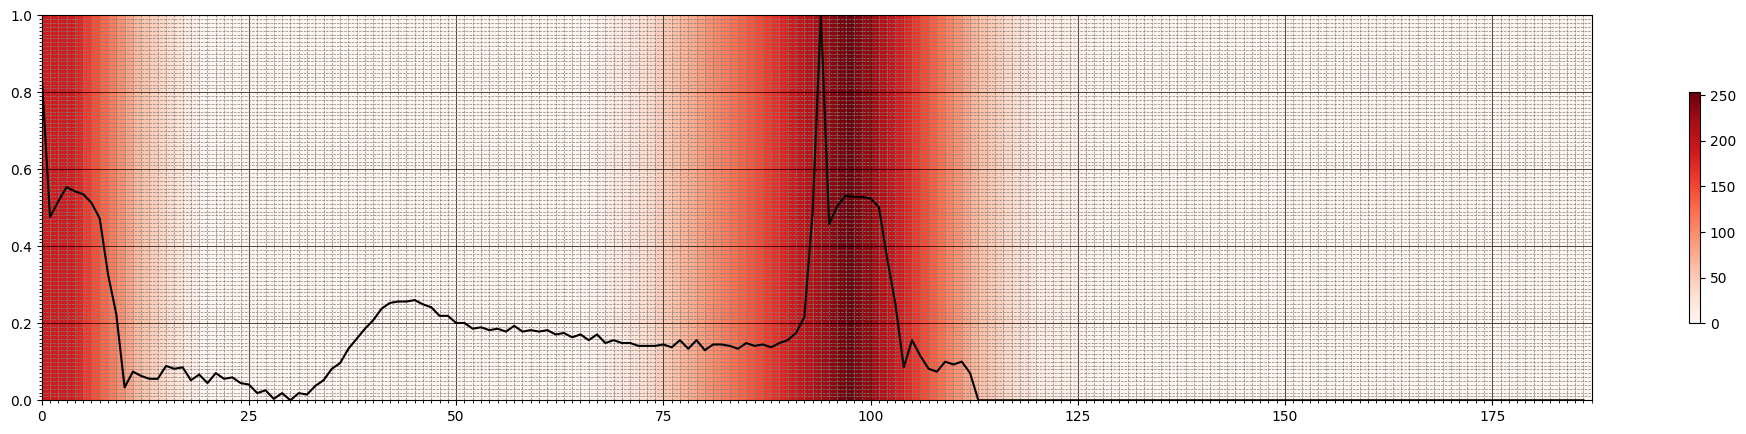

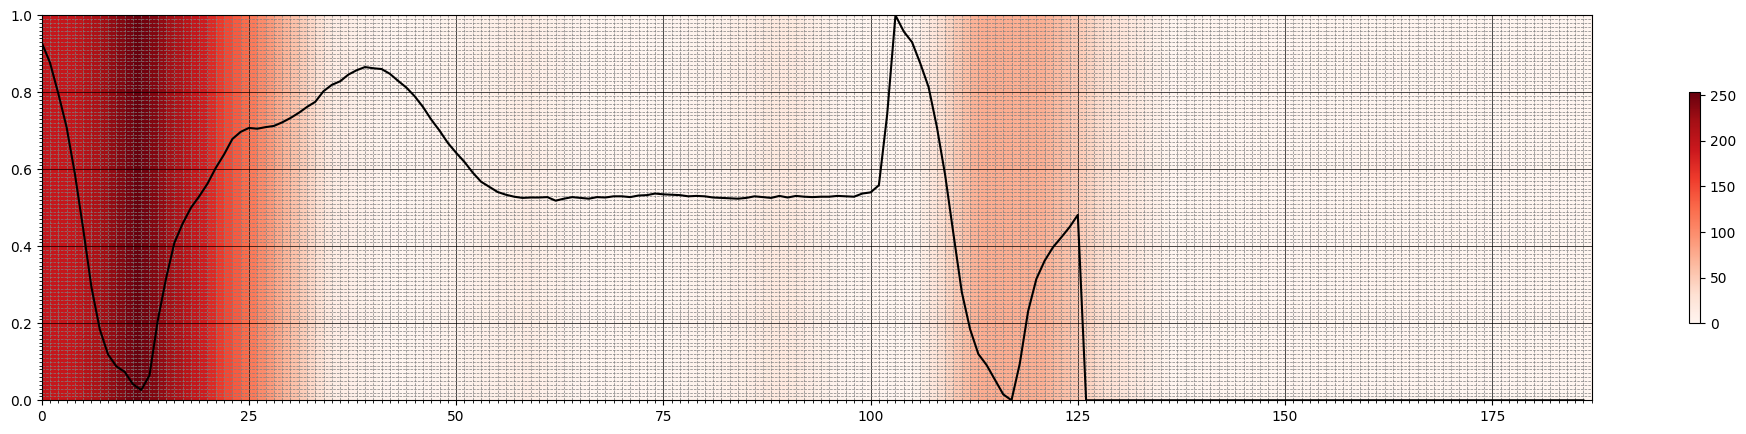

In [22]:
# Grad-CAMs that belongs to class Q
for i in range(20306,20311):
  get_prediction(i)

To say that an ECG is normal, a doctor will compare it to a reference ECG signal and check if they are similar. If the signals are not similar, there is a pathology. In the figure below, you can see what a reference ECG signal looks like. 

<div>
<img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/raw/main/docs/source/_figures/ecg.png" width="400" height="400"/>
</div>

<font size=1> Source: [Algarni et al., 2020](https://link.springer.com/article/10.1007/s11042-020-09369-5)

<font color='green'>

#### Question 1: What can we learn from the Grad-Cam heatmaps for each class?

<font color='grey'>

#### Your Answer: 

We can see that the model's prediction looks at the beginning of the signal and the peaks, mainly focusing on the beginning of some signals.

For example, Grad-CAMs belonging to class F had peaks larger than the other classes. Grad-CAMs that belong to class Q have peeks to the bottom of the figures and peeks that are not tall compared to the other ECGs. Those peeks go up again after going down.

In [23]:
# remove the folder with unzipped data
!rm -r ../data/dataset_ECG/ECG_test_data